In [1]:
import numpy as np
import pandas as pd
from glob import glob

from os import path, makedirs
import copy

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat

from utils.io import get_args, save_args, get_secondlevel_dir
 

In [2]:
np.random.seed(2022)

In [3]:
args = get_args(['-overwrite'])

secondlevel_dir = get_secondlevel_dir(args)

thirdlevel_dir = secondlevel_dir.replace('2ndlevels', '3rdlevels').replace(f'dataset-{args.dataset}/', '')
makedirs(thirdlevel_dir, exist_ok=True)
save_args(args, thirdlevel_dir)

# make secondlevel dir a flexible template
secondlevel_dir = secondlevel_dir.replace(f'-{args.dataset}/', '-%s/')

ridx, cidx = np.tril_indices(args.nROI, -1)


# Between Datasets

In [5]:
dataset1_maxTs = glob(path.join(secondlevel_dir % '1', '*maxT.csv'))
dataset2_maxTs = glob(path.join(secondlevel_dir % '2', '*maxT.csv'))

dataset1_shortened = [f.split('/')[-1] for f in dataset1_maxTs]
dataset2_shortened = [f.split('/')[-1] for f in dataset2_maxTs]

overlapping_results = [f for f in dataset1_shortened if f in dataset2_shortened]

# MaxT -> Edge Shuffle

model-trialType_contrast-probe_success-probe_fail_datatype-edge_2ndlevel-maxT.csv 0 1 22 1.0
model-trialType_contrast-probe_success_datatype-edge_2ndlevel-maxT.csv 2 17 355 0.0029997000299970002


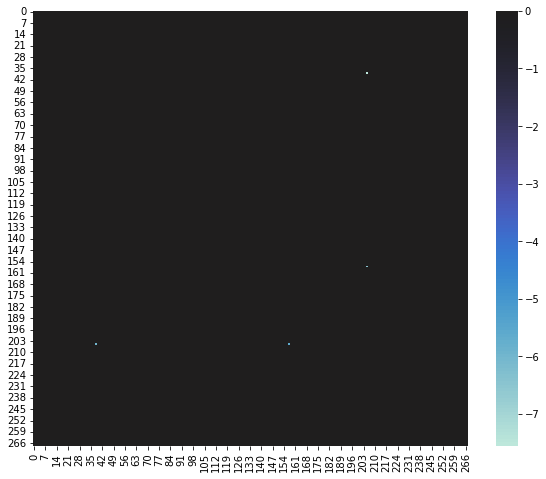

model-trialType_contrast-probe_fail+probe_success_datatype-roi_2ndlevel-maxT.csv 1011 1429 4743 9.999000099990002e-05


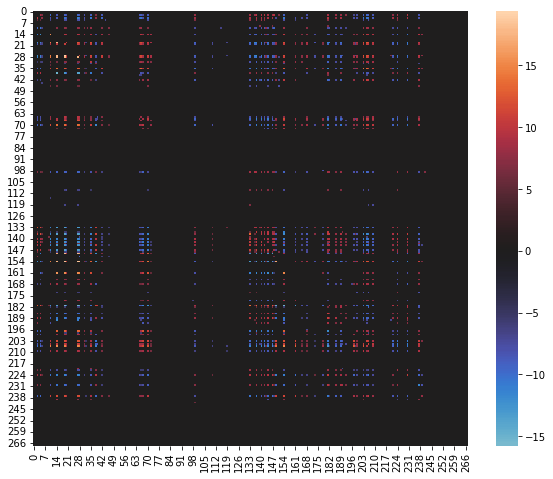

model-trialType_contrast-common_fail_datatype-roi_2ndlevel-maxT.csv 12 25 425 9.999000099990002e-05


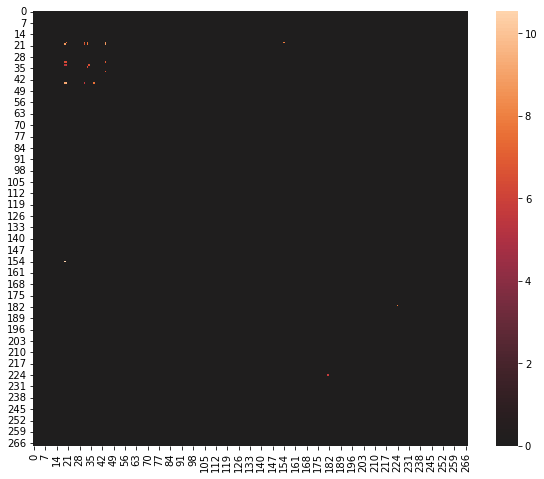

model-trialType_contrast-probe_fail+probe_success_datatype-edge_2ndlevel-maxT.csv 7 49 413 9.999000099990002e-05


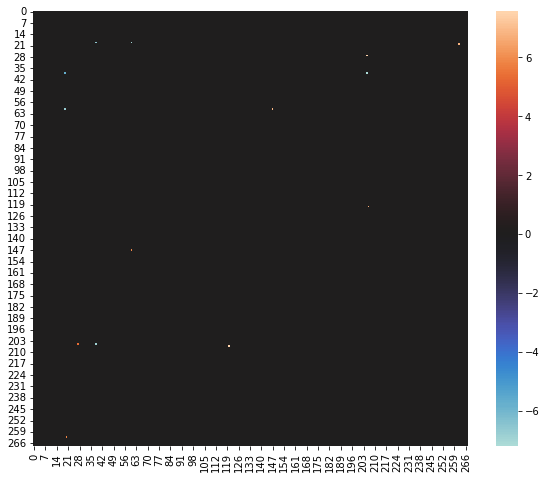

model-VTCcorr_contrast-VTCcorr_datatype-edge_2ndlevel-maxT.csv 0 0 3 1.0
model-trialType_contrast-probe_fail_datatype-roi_2ndlevel-maxT.csv 418 640 1948 9.999000099990002e-05


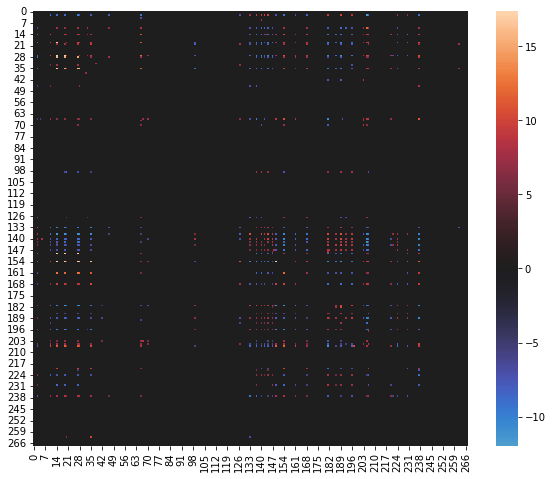

model-VTC_convolved_contrast-vtc_datatype-edge_2ndlevel-maxT.csv 0 0 0 1.0
model-trialType_contrast-common_fail_datatype-edge_2ndlevel-maxT.csv 0 1 0 1.0
model-trialType_contrast-probe_success_datatype-roi_2ndlevel-maxT.csv 519 729 5285 9.999000099990002e-05


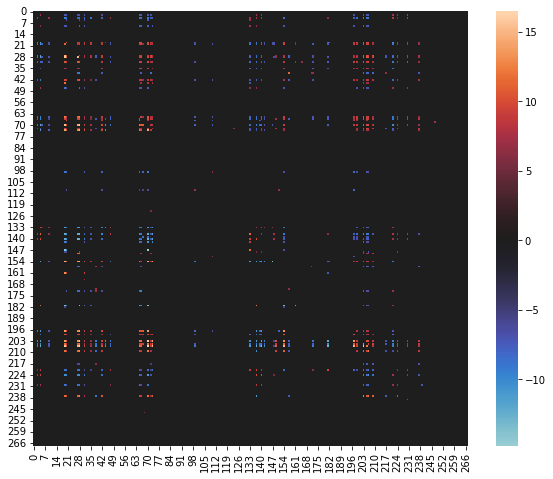

model-trialType_contrast-probe_success-probe_fail_datatype-roi_2ndlevel-maxT.csv 1 1 194 0.004399560043995601


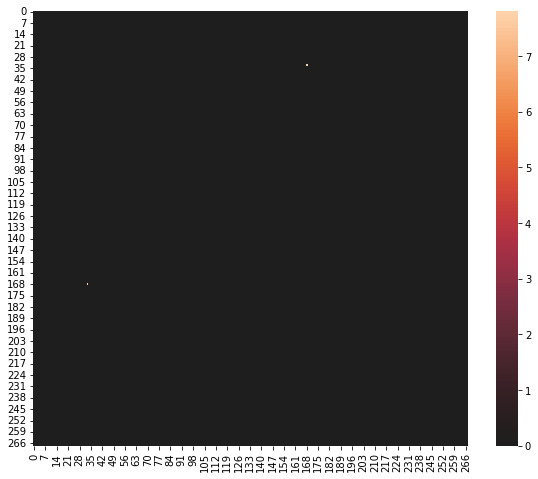

model-trialPrecursor_datatype-edge_2ndlevel-maxT.csv 0 0 0 1.0
model-trialType_contrast-probe_fail_datatype-edge_2ndlevel-maxT.csv 0 20 145 1.0


In [6]:
non_zero_df = pd.DataFrame()

indices = np.arange(0, len(ridx))

for res in overlapping_results:
    #check to see if files exist, skip if not overwriting
    out_file = path.join(thirdlevel_dir, res)
    if path.exists(out_file) and not args.overwrite:
        pass
    else:
    
        # load res as lower triangle
        res_d1 = pd.read_csv(path.join(secondlevel_dir % '1', res), header=None).values[ridx, cidx]
        res_d2 = pd.read_csv(path.join(secondlevel_dir % '2', res), header=None).values[ridx, cidx]

        bool_d1 = np.where(res_d1!=0, 1, 0) # take lower triangle
        bool_d2 = np.where(res_d2!=0, 1, 0)
        
        pos_overlap = (np.where(res_d1>0, 1, 0) * np.where(res_d2>0, 1, 0))
        neg_overlap = (np.where(res_d1<0, 1, 0) * np.where(res_d2<0, 1, 0))

        obs_overlap = np.sum(pos_overlap + neg_overlap)
            
        d1_copy = copy.deepcopy(res_d1)
        d2_copy = copy.deepcopy(res_d2)
        
        shuffle_overlaps = np.full((args.n_perms,), np.nan)
        for p in range(args.n_perms):

            np.random.shuffle(indices)
            shuffled_d1 = d1_copy[indices]

            np.random.shuffle(indices)
            shuffled_d2 = d2_copy[indices]
            
            # get overlap
            shuff_pos_overlap = (np.where(shuffled_d1>0, 1, 0) * np.where(shuffled_d2>0, 1, 0))
            shuff_neg_overlap = (np.where(shuffled_d1<0, 1, 0) * np.where(shuffled_d2<0, 1, 0))

            shuffle_overlaps[p] = np.sum(shuff_pos_overlap + shuff_neg_overlap)

        print(res, obs_overlap, bool_d1.sum(), bool_d2.sum(), (np.sum(shuffle_overlaps >= obs_overlap) + 1) / (args.n_perms+1))

        mean_ADJ = np.full((args.nROI, args.nROI), 0.0)
        mean_ADJ[ridx, cidx] = res_d1 * (pos_overlap + neg_overlap)
        mean_ADJ = mean_ADJ.T
        mean_ADJ[ridx, cidx] = res_d2 * (pos_overlap + neg_overlap)

        pd.DataFrame(mean_ADJ).to_csv(out_file, index=False, header=False)
        
        if np.sum(mean_ADJ!=0)>0:

            # add sig edge info to dataframe, if datatype = edge
            if 'datatype-edge' in res:
                # get contrast name
                contrast_name = res.split('contrast-')[1].split('_datatype-')[0]
                contrast_name

                non_zeros = np.where(mean_ADJ[ridx, cidx])[0]
                non_zero_res = []
                for non_zero in non_zeros:
                    non_zero_res.append([ridx[non_zero], cidx[non_zero], mean_ADJ[ridx[non_zero], cidx[non_zero]]])

                curr_non_zero_df = pd.DataFrame(non_zero_res, columns=['ROI1', 'ROI2', f'tstat_{contrast_name}'])
                non_zero_df = non_zero_df.append(curr_non_zero_df)

            plt.figure(figsize=(10, 8))
            _ = sns.heatmap(mean_ADJ, square=True, center=0)
            plt.show()
            plt.close()

In [9]:
non_zero_df.to_csv(path.join(thirdlevel_dir, 'max-T_non-zero.csv'))
non_zero_df

,ROI1,ROI2,tstat_probe_success,tstat_probe_fail+probe_success
0,205,38,-5.995275,NaN
1,205,157,-5.616775,NaN
0,38,19,NaN,-5.703949
1,60,19,NaN,-6.738377
2,147,60,NaN,5.908435
3,205,27,NaN,5.367117
4,205,38,NaN,-6.914539
5,206,120,NaN,7.570612
6,262,20,NaN,5.819266


# NBS -> Node Shuffle

In [ ]:
indices = np.arange(0, args.nROI)

In [ ]:
for res in overlapping_results:
    res = res.replace("maxT", "NBS")
    
    #check to see if files exist, skip if not overwriting
    out_file = path.join(thirdlevel_dir, res)
    if path.exists(out_file) and not args.overwrite:
        pass
    else:

        res_d1 = pd.read_csv(path.join(secondlevel_dir % '1', res), header=None).values
        res_d2 = pd.read_csv(path.join(secondlevel_dir % '2', res), header=None).values

        bool_d1 = np.where(res_d1!=0, 1, 0)
        bool_d2 = np.where(res_d2!=0, 1, 0)
        
        pos_d1 = np.where(res_d1>0, 1, 0)
        neg_d1 = np.where(res_d1<0, 1, 0)
        pos_d2 = np.where(res_d2>0, 1, 0)
        neg_d2 = np.where(res_d2<0, 1, 0)

        obs_overlap = np.sum(
            (pos_d1*pos_d2)[ridx, cidx] + (neg_d1*neg_d2)[ridx, cidx]
        )
        
        d1_copy = copy.deepcopy(res_d1)
        d2_copy = copy.deepcopy(res_d2)
        shuffle_overlaps = np.full((args.n_perms,), np.nan)
        for p in range(args.n_perms):
            np.random.shuffle(indices)
            shuffled_d1 = d1_copy[np.ix_(indices, indices)]

            np.random.shuffle(indices)
            shuffled_d2 = d2_copy[np.ix_(indices, indices)]
            
            shuff_pos_d1 = np.where(shuffled_d1>0, 1, 0)
            shuff_neg_d1 = np.where(shuffled_d1<0, 1, 0)
            shuff_pos_d2 = np.where(shuffled_d2>0, 1, 0)
            shuff_neg_d2 = np.where(shuffled_d2<0, 1, 0)

            shuffle_overlaps[p] = np.sum(
                (shuff_pos_d1*shuff_pos_d2)[ridx, cidx] + (shuff_neg_d1*shuff_neg_d2)[ridx, cidx]
            )

        print(res, obs_overlap, bool_d1[ridx, cidx].sum(), bool_d2[ridx, cidx].sum(), (np.sum(shuffle_overlaps >= obs_overlap) + 1) / (args.n_perms+1))
        
        mean_ADJ = np.full((args.nROI, args.nROI), 0.0)
        mean_ADJ[ridx, cidx] = (res_d1 * ((pos_d1*pos_d2) + (neg_d1*neg_d2)))[ridx, cidx]
        mean_ADJ = mean_ADJ.T
        mean_ADJ[ridx, cidx] = (res_d2 * ((pos_d1*pos_d2) + (neg_d1*neg_d2)))[ridx, cidx]
        

        pd.DataFrame(mean_ADJ).to_csv(out_file, index=False, header=False)

        if np.sum(mean_ADJ!=0)>0:
            plt.figure(figsize=(10, 8))
            _ = sns.heatmap(mean_ADJ, square=True, center=0)
            plt.show()
            plt.close()
            
    

# Compare 2ndlevels with CPM edges

In [ ]:
CPM_mat = loadmat('saCPM.mat')

high_edges = CPM_mat['high_attention_mask']
_ = sns.heatmap(high_edges)
plt.show()

low_edges = CPM_mat['low_attention_mask']
_ = sns.heatmap(low_edges)
plt.show()

CPM_edges = high_edges + low_edges
_ = sns.heatmap(CPM_edges)
plt.show()
print((CPM_edges!=0).sum()/2)

In [ ]:
indices = np.arange(0, args.nROI)

In [ ]:
[overlapping_results[i] for i in [0,5,11]]

In [ ]:
1/10001

## Assume that edges which are positive for CO-CE (normal contrast or trial-precursor) are members of high attention, negative part of low attention

In [ ]:
[overlapping_results[i] for i in [0,11]]

In [ ]:
for res in [overlapping_results[i] for i in [0,11]]:
    res = res.replace("maxT", "NBS")
    
    res_d1 = pd.read_csv(path.join(secondlevel_dir % '1', res), header=None).values
    res_d2 = pd.read_csv(path.join(secondlevel_dir % '2', res), header=None).values
    
    for dset in ['1', '2']:
        dset_res = pd.read_csv(path.join(secondlevel_dir % dset, res), header=None).values
        
        obs_overlap = (((dset_res>0)*high_edges).sum() + ((dset_res<0)*low_edges).sum())/2
        
        dset_copy = copy.deepcopy(dset_res)
        shuffle_overlaps = np.full((args.n_perms,), np.nan)
        
        for p in range(args.n_perms):
            np.random.shuffle(indices)
            shuffled_d = dset_copy[np.ix_(indices, indices)]

            shuffle_overlaps[p] = np.sum(
                (((shuffled_d>0)*high_edges).sum() + ((shuffled_d<0)*low_edges).sum())/2
            )

        print(res, dset, obs_overlap, (dset_res!=0).sum()/2, (np.sum(shuffle_overlaps >= obs_overlap) + 1) / (args.n_perms+1))

## Assume positive for VTC is low attention network and vice versa

In [ ]:
for res in [overlapping_results[i] for i in [5]]:
    res = res.replace("maxT", "NBS")
    
    res_d1 = pd.read_csv(path.join(secondlevel_dir.replace(f'-{args.dataset}/', '-1/'), res), header=None).values
    res_d2 = pd.read_csv(path.join(secondlevel_dir.replace(f'-{args.dataset}/', '-1/'), res), header=None).values
    
    for dset in ['1', '2']:
        dset_res = pd.read_csv(path.join(secondlevel_dir % dset, res), header=None).values
        
        obs_overlap = (((dset_res<0)*high_edges).sum() + ((dset_res>0)*low_edges).sum())/2
        
        dset_copy = copy.deepcopy(dset_res)
        shuffle_overlaps = np.full((args.n_perms,), np.nan)
        
        for p in range(args.n_perms):
            np.random.shuffle(indices)
            shuffled_d = dset_copy[np.ix_(indices, indices)]

            shuffle_overlaps[p] = np.sum(
                (((shuffled_d<0)*high_edges).sum() + ((shuffled_d>0)*low_edges).sum())/2
            )

        print(res, dset, obs_overlap, (dset_res!=0).sum()/2, (np.sum(shuffle_overlaps >= obs_overlap) + 1) / (args.n_perms+1))

In [ ]:
# looking at total overlap in dataset 2
print(((dset_res!=0)*(high_edges+low_edges)).sum()/2)

# assumption matching overlap
print( ((dset_res<0)*high_edges).sum()/2 , ((dset_res>0)*low_edges).sum()/2 )

# assumption violating overlap, which wasn't included in the test above
print( ((dset_res>0)*high_edges).sum()/2 , ((dset_res<0)*low_edges).sum()/2 )

### chi square test of independence 

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
# build cross tab table
#       HAN    |    LAN
# POS |  3     |    20
# NEG | 35     |     0

rc_table = np.array([
    [((dset_res>0)*high_edges).sum()/2, ((dset_res>0)*low_edges).sum()/2],
    [((dset_res<0)*high_edges).sum()/2, ((dset_res<0)*low_edges).sum()/2]
])


In [ ]:
stat, p, ddof, expected_freq = chi2_contingency(rc_table, correction=True)
print(stat, p, ddof, expected_freq)

In [ ]:
0.6*(10**(-10))

In [ ]:
10**(-10)

In [ ]:
2^2